In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import sys
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from operator import itemgetter
import lmfit
from scipy import signal
from scipy import fftpack
from skimage import util
import operator
from numpy import NaN, Inf, arange, isscalar, asarray, array
import pylab
import inspect

run = ['001','002','003','004','005','006','007','008','009','010',
       '011','012','013','014','015','016','017','018','019','020', 
       '021','022','023','024','025','026','027','028','029','030',
       '031','032','033','034','035','036']
kx_ind = [0.0125,  0.0150,  0.0175,  0.0200,  0.0225,  0.0250,  0.0275,  0.0300,  0.0325,  0.0350,
          0.0375,  0.0400,  0.0425,  0.0450,  0.0475,  0.0500,  0.1000,  0.2000,  0.3000,  0.4000,
          0.5000,  0.6000,  0.7000,  0.8000,  0.9000,  1.0000,  1.1000,  1.2000,  1.3000,  1.4000,
          1.5000,  1.6000,  1.7000,  1.8000,  1.9000,  2.0000]
#        [0.3000,  0.4000,
#         0.5000,  0.6000,  0.7000,  0.8000,  0.9000,  1.0000,  1.1000,  1.2000,  1.3000,  1.4000,
#         1.5000,  1.6000,  1.7000,  1.8000,  1.9000,  2.0000]

##############################################################################################################
###############################################    FUNCTIONS     #############################################
##############################################################################################################


#############################################    PEAK DETECTOR     ###########################################

def peakdet(v, delta, x = None):
    maxtab = []
    mintab = []
       
    if x is None:
        x = arange(len(v))
    
    v = asarray(v)
    
    if len(v) != len(x):
        sys.exit('Input vectors v and x must have same length')
    
    if not isscalar(delta):
        sys.exit('Input argument delta must be a scalar')
    
    if delta <= 0:
        sys.exit('Input argument delta must be positive')
    
    mn, mx = Inf, -Inf
    mnpos, mxpos = NaN, NaN
    
    lookformax = True
    
    for i in arange(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]
        
        if lookformax:
            if this < mx-delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn+delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True

    return array(maxtab), array(mintab)

#############################################    FITTING MODEL     ###########################################

def model(t, decay):  # , omega, resid):
    return np.exp(-t/decay)  # * np.cos(omega * t) + resid
gmodel = lmfit.Model(model)

#############################################    DIAGNOSTIC TOOL     ###########################################

def diag_w7x(filename, minlim=None, maxlim=None, spectrogram=False, plot=False, my_data=None, k=None):
    if maxlim is not None and minlim is None:
        nummy = run[0:maxlim]
        if k is not None:
            kx = kx_ind[k:(maxlim+k)]
        else:
            kx = kx_ind[0:maxlim]
    elif minlim is not None and maxlim is None:
        nummy = run[minlim:len(run)]
        kx = kx_ind[minlim:len(run)]
    elif minlim is not None and maxlim is not None:
        nummy = run[minlim:maxlim]
        if k is not None:
            kx = kx_ind[(k+minlim):(maxlim+k)]
        else:
            kx = kx_ind[minlim:maxlim]
    if minlim is None and maxlim is None:
        nummy = run
        kx = kx_ind   
    

    dataset = [('./{0}/GAMDIAGions_0{1}.dat'.format(filename, index), index) for index in nummy]     
    datalist = [ ( pylab.loadtxt(datapath), label) for datapath, label in dataset]  # Load the .dat files as an array

    if plot == True and type(my_data) == type(None):
        plt.figure(figsize=(13, 6.5))
        plt.axhline(y=0, color='black', linestyle='dashed')
        plt.title("{0}".format(filename), fontsize=30)
        #plt.xscale('log')
        plt.xlabel('Time ($a / v_{ti}$)',fontsize=19)
        plt.ylabel('$\phi (t) / \phi (0)$',fontsize=19)
    
    if type(my_data) == type(None):
        integ = []
        rmsvl = []
        decay = []
        osrat = []
        burat = []
        g1rat = []
        g2rat = []
        dcrat = []
        perid = []
        perbd = []
        pekti = []
    else:
        integ = my_data[0, :].tolist()
        rmsvl = my_data[1, :].tolist()
        decay = my_data[2, :].tolist()
        osrat = my_data[3, :].tolist()
        burat = my_data[4, :].tolist()
        g1rat = my_data[5, :].tolist()
        g2rat = my_data[6, :].tolist()
        dcrat = my_data[7, :].tolist()
        perid = my_data[8, :].tolist()
        perbd = my_data[9, :].tolist()
        pekti = my_data[10, :].tolist()
            
    for data, label in datalist:
        E = (data[:,1]*(1/data[0, 1]))
        t = data[:,0]
        
        if plot == True:
            plt.plot(t, E, label='{0}'.format(label))
            if len(nummy) < 11:
                plt.legend(kx, title='$k_{x}$', fontsize=14)
                plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        intefield = np.trapz(E, t)
        integ.append(intefield)
        rms = np.sqrt(np.mean(E**2))
        rmsvl.append(rms)
        
        result, OS, BR, GR1, GR2, DR, PE, PE2, TP = nucleus_w7x(E, t, label, diag=False)   
        
        decay.append(result.best_values.get('decay'))
        osrat.append(OS)
        burat.append(BR)
        g1rat.append(GR1)
        g2rat.append(GR2)
        dcrat.append(DR)
        perid.append(PE)
        perbd.append(PE2)
        pekti.append(TP)

    if type(my_data) != type(None):
        plt.show()
    
        if spectrogram == True:
            ########  SPECTROGRAM
            f_s = len(data[:, 0]) / data[-1, 0]
            E = (data[:,1]*(1/data[0, 1]))
            M = 1024
            slices = util.view_as_windows(E, window_shape=(M,), step=2)
            win = np.hanning(M + 1)[:-1]
            slices = slices * win
            slices = slices.T
            spectrum = np.fft.fft(slices, axis=0)[:M // 2 + 1:-1]
            spectrum = np.abs(spectrum)
            S = np.abs(spectrum)
            S = 20 * np.log10(S / np.max(S))
            plt.figure()
            plt.imshow(S, origin='lower', cmap='viridis')
            plt.title(str(label), fontsize=30)
            plt.axis('tight')
            plt.ylabel('Frequency [Hz]')
            plt.xlabel('Time ($a / v_{ti}$)')
            #plt.ylim([0, 0.3])
    

    f_s = len(data[:, 0]) / data[-1, 0]
    my_data = np.array([integ, rmsvl, decay, osrat, burat, g1rat, g2rat, dcrat, perid, perbd, pekti])
    return datalist, nummy, kx, my_data, E, t, f_s, label

#############################################    DIAGNOSTIC PLOTTER     ###########################################

def retrieve_name(var):
        """
        Gets the name of var. Does it from the out most frame inner-wards.
        :param var: variable to get name from.
        :return: string
        """
        for fi in reversed(inspect.stack()):
            names = [var_name for var_name, var_val in fi.frame.f_locals.items() if var_val is var]
            if len(names) > 0:
                return names[0]

def diag_plotter(kx, my_data, alldata=False, fig=True):
    
    integ = my_data[0, :]
    rmsvl = my_data[1, :]
    decay = my_data[2, :]
    osrat = my_data[3, :]
    burat = my_data[4, :]
    g1rat = my_data[5, :]
    g2rat = my_data[6, :]
    dcrat = my_data[7, :]
    perid = my_data[8, :]
    perbd = my_data[9, :]
    pekti = my_data[10, :]
    
    if fig == True:
        fig = plt.figure(figsize=(30, 20))
    else:
        fig = fig
        
    ax1 = fig.add_subplot(331)
    ax2 = fig.add_subplot(332)
    ax3 = fig.add_subplot(333)
    ax4 = fig.add_subplot(334)
    ax5 = fig.add_subplot(335)
    ax6 = fig.add_subplot(336)
    ax7 = fig.add_subplot(337)
    ax8 = fig.add_subplot(338)
    ax9 = fig.add_subplot(339)


    ########  top
    ax1.plot(kx, integ)
    ax2.plot(kx, rmsvl)
    ax3.plot(kx, decay)
    
    #ax1.set_xlabel('$k_{x} \\rho_{ti}$')
    #ax2.set_xlabel('$k_{x} \\rho_{ti}$')
    #ax3.set_xlabel('$k_{x} \\rho_{ti}$')

    ax1.title.set_text('Integral')
    ax2.title.set_text('RMS value')
    ax3.title.set_text('Decay length')

    ########  mid
    ax4.plot(kx, osrat)
    ax5.plot(kx, g2rat, label='2nd growth ratio')
    ax5.plot(kx, dcrat, label='Decay Ratio')
    ax6.plot(kx, pekti, label='{0}'.format(retrieve_name(my_data)))
    
    #ax4.set_xlabel('$k_{x} \\rho_{ti}$')
    #ax5.set_xlabel('$k_{x} \\rho_{ti}$')
    #ax6.set_xlabel('$k_{x} \\rho_{ti}$')
    
    ax4.title.set_text('Overshoot ratio')
    ax5.title.set_text('2nd growth ratio')
    ax6.title.set_text('Peak time')
    ax6.legend(loc="lower right")
    ax5.legend()
    
    ########  bottom
    #ax3.title.set_text('RMS')
    ax7.plot(kx, g1rat)
    ax8.plot(kx, burat)
    ax9.plot(kx, perid)
    ax9.plot(kx, perbd)
    
    ax7.title.set_text('Bump growth ratio')
    ax8.title.set_text('Bump ratio')
    ax9.title.set_text('Period')
    
    ax7.set_xlabel('$k_{x} \\rho_{ti}$')
    ax8.set_xlabel('$k_{x} \\rho_{ti}$')
    ax9.set_xlabel('$k_{x} \\rho_{ti}$')

    if alldata == False:
        fig.show()

    return fig
#############################################    TROUBLESHOOTER     #############################################
def troubleshooter(E, t, f_s, label, spectrogram=True):
    #E = (data[:,1]*(1/data[0, 1]))
    #t = data[:, 0]
    #f_s = len(data[:, 0]) / data[-1, 0]
    X = fftpack.fft(E)
    freqs = fftpack.fftfreq(len(E)) * f_s

    fig = plt.figure(figsize=(13, 13))
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    ax1.stem(freqs, np.abs(X))
    ax1.set_xlabel('Frequency in Hertz [Hz]')
    ax1.set_ylabel('Frequency Domain (Spectrum) Magnitude')
    ax1.set_xlim(0, 0.55)  # f_s / 2)
    #ax2.set_ylim(-2, 2)
    ax2.set_xlim(0, 500)
    ax2.plot(t, E, label='{0}'.format(label))
    ax2.axhline(y=0, color='black', linestyle='dashed')
    
    maxtab, mintab, OS, BR, GR1, GR2, DR, PE, PE2, TP, a, b1, b2, e, i, c, o = nucleus_w7x(E, t, label, diag=True)
    
    if type(b1) == float:
        n = ['a', 'e', 'i', 'c', 'o']
        x = np.array([a, e, i, c, o])[:,1]
        y = np.array([a, e, i, c, o])[:,0]
    else:
        n = ['a', 'b1', 'b2', 'e', 'i', 'c', 'o']
        x = np.array([a, b1, b2, e, i, c, o])[:,1]
        y = np.array([a, b1, b2, e, i, c, o])[:,0]
    ax2.scatter(y,x, color='blue')
    for r, txt in enumerate(n):
        ax2.annotate(txt, (y[r], x[r]))
    ax2.scatter(e[0], e[1], color='green')
    ax2.scatter(maxtab[:, 0], maxtab[:, 1], color='red')
    ax2.scatter(mintab[:, 0], mintab[:, 1], color='blue')
    #ax2.set_xlim(-10, 100)
    print('Overshoot ratio (OS): ' + str(OS))
    print('Bump ratio (BR): ' + str(BR))
    print('Bump growth ratio (GR1): ' + str(GR1))
    print('2nd growth ratio (GR2): ' + str(GR2))
    print('Period (PE): ' + str(PE))
    print('Peak time (TP): ' + str(TP))
    fig.show()
    
    if spectrogram == True:
            ########  SPECTROGRAM
            M = 1024
            slices = util.view_as_windows(E, window_shape=(M,), step=2)
            win = np.hanning(M + 1)[:-1]
            slices = slices * win
            slices = slices.T
            spectrum = np.fft.fft(slices, axis=0)[:M // 2 + 1:-1]
            spectrum = np.abs(spectrum)
            S = np.abs(spectrum)
            S = 20 * np.log10(S / np.max(S))
            plt.figure(figsize=(13, 6.5))
            plt.imshow(S, origin='lower', cmap='viridis')
            plt.title(str(label), fontsize=30)
            plt.axis('tight')
            plt.ylabel('Frequency [Hz]')
            plt.xlabel('Time ($a / v_{ti}$)')
            #plt.ylim([0, 0.3])
    plt.show()

    
    return 
    

In [3]:
def nucleus_w7x(E, t, label, diag=False):
    # Peak detection
    maxtab, mintab = peakdet(E, 0.00005, x=t)
    max_control, min_contol = peakdet(E[250:], 0.00005, x=t[250:])
    
    # A fitting to the peak values to get the decay coefficient:
    result = gmodel.fit(maxtab[:300, 1], t=maxtab[:300, 0], decay=17, nan_policy='propagate')

    # Can you guess the residual?
    if 0.95 <= np.abs(E[-1]/mintab[0, 1]) <= 1.02:
        print('residual? :' + str(mindec[0, 1]))
        
    # Maxpeaks
    a = maxtab[0, :]  # Initial point (Expected to be ==1)
    
    if np.shape(maxtab) != (2, 2):  # If there are more points than a and i:
        b1 = maxtab[1, :]  # Second Peak
        i = maxtab[2, :]  #1 ZF peak (i in LHD)
    else:
        i = maxtab[1, :]
        b1 = i
        print('i point is the first one')

    if max_control[0, 1] < i[1] and np.shape(max_control) != (1, 2):  # Locate the control point
        c = max_control[1, :]
    else:
        c = max_control[0, :]           
    
    # Minpeaks
    b2 = mintab[0, :]  # (Technically) The lowest point
    e = mintab[1, :]
        
    min_index, min_value = min(enumerate(mintab[:, 1]), key=operator.itemgetter(1))  
    f = mintab[min_index, :]  # This determines the minimum peak

    
    # The initial bump is not detected if the points e & i are both > 0.32
    if b1[1] < 0.32 and b1[0] > 60:
    #    print('No first bump. b1 located at: ' + str(b1[0]))
        BR = np.nan
        i = b1
        e = b2
        b1, b2 = np.nan, np.nan
        GR1, GR2, PE2 = np.nan, np.nan, np.nan
    else:
        BR = np.abs(b2[1] / a[1])  # Bumpo rati3o
        GR1 = np.abs((e[1]-a[1]) / (b2[1]-a[1]))  # Bump growth ratio
        GR2 = np.abs(e[1] / b2[1])  # 2nd Growth ratio
        PE2 = np.abs(e[0] - b2[0])
        
    if e[1] > 0.38:
    #    print('No valid e point')
        e = f
        if c[0] > 100 and i[0] >= c[0]:
            i = c
        else: 
            c = [np.nan, np.nan]
            i = [np.nan, np.nan]
        o = [np.nan, np.nan]
        DR = np.nan
        PE = np.nan
    else:
        if np.shape(mintab) != (2, 2):
            o = mintab[2, :]
            DR = np.abs(o[1] / e[1])  # Decay ratio
            PE = np.abs(o[0] - e[0])  # Period
        else:
            o = [np.nan, np.nan]
            DR = np.nan
            PE = np.nan
    #        print('The o point is the next one')
    
    TP = e[0]         # The time when the peak hits
    OS = np.abs(e[1] / a[1])  # Overshoot ratio
        
    #print('---------------------------------')
            
    if diag == True:
        print('Diag mode on')
        
        return maxtab, mintab, OS, BR, GR1, GR2, DR, PE, PE2, TP, a, b1, b2, e, i, c, o
    else:
        return result, OS, BR, GR1, GR2, DR, PE, PE2, TP

In [ ]:
%matplotlib inline

In [ ]:
troubleshooter(E, t, f_s, label, spectrogram=False)

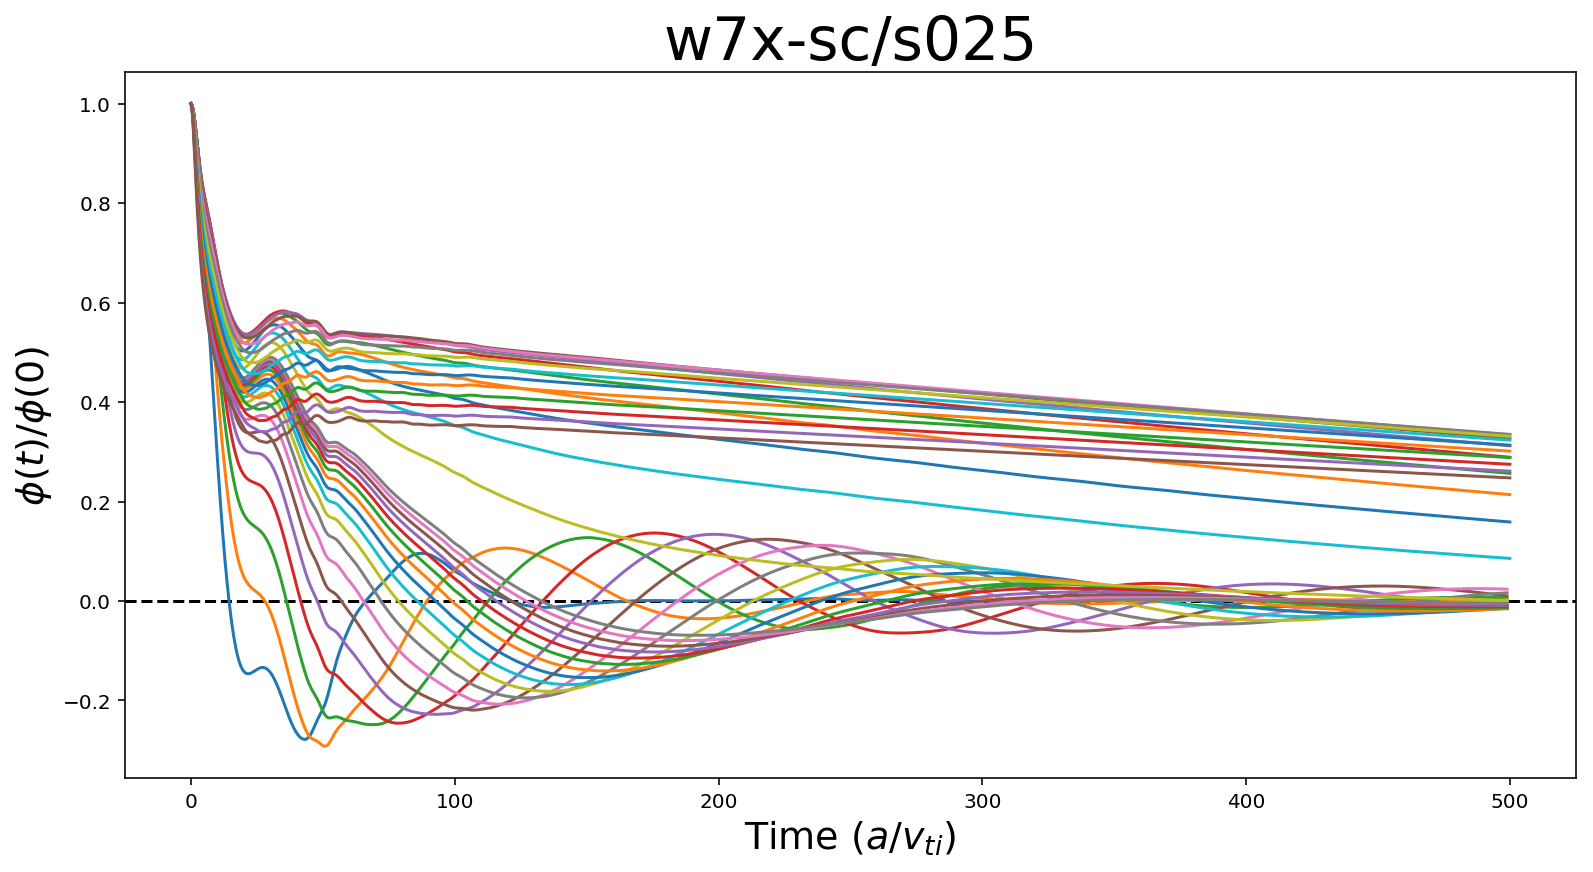

[0.0125 0.015  0.0175 0.02   0.0225 0.025  0.0275 0.03   0.0325 0.035
 0.0375 0.04   0.0425 0.045  0.0475 0.05   0.1    0.2    0.3    0.4
 0.5    0.6    0.7    0.8    0.9    1.     1.1    1.2    1.3    1.4
 1.5    1.6    1.7    1.8    1.9    2.    ]


/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


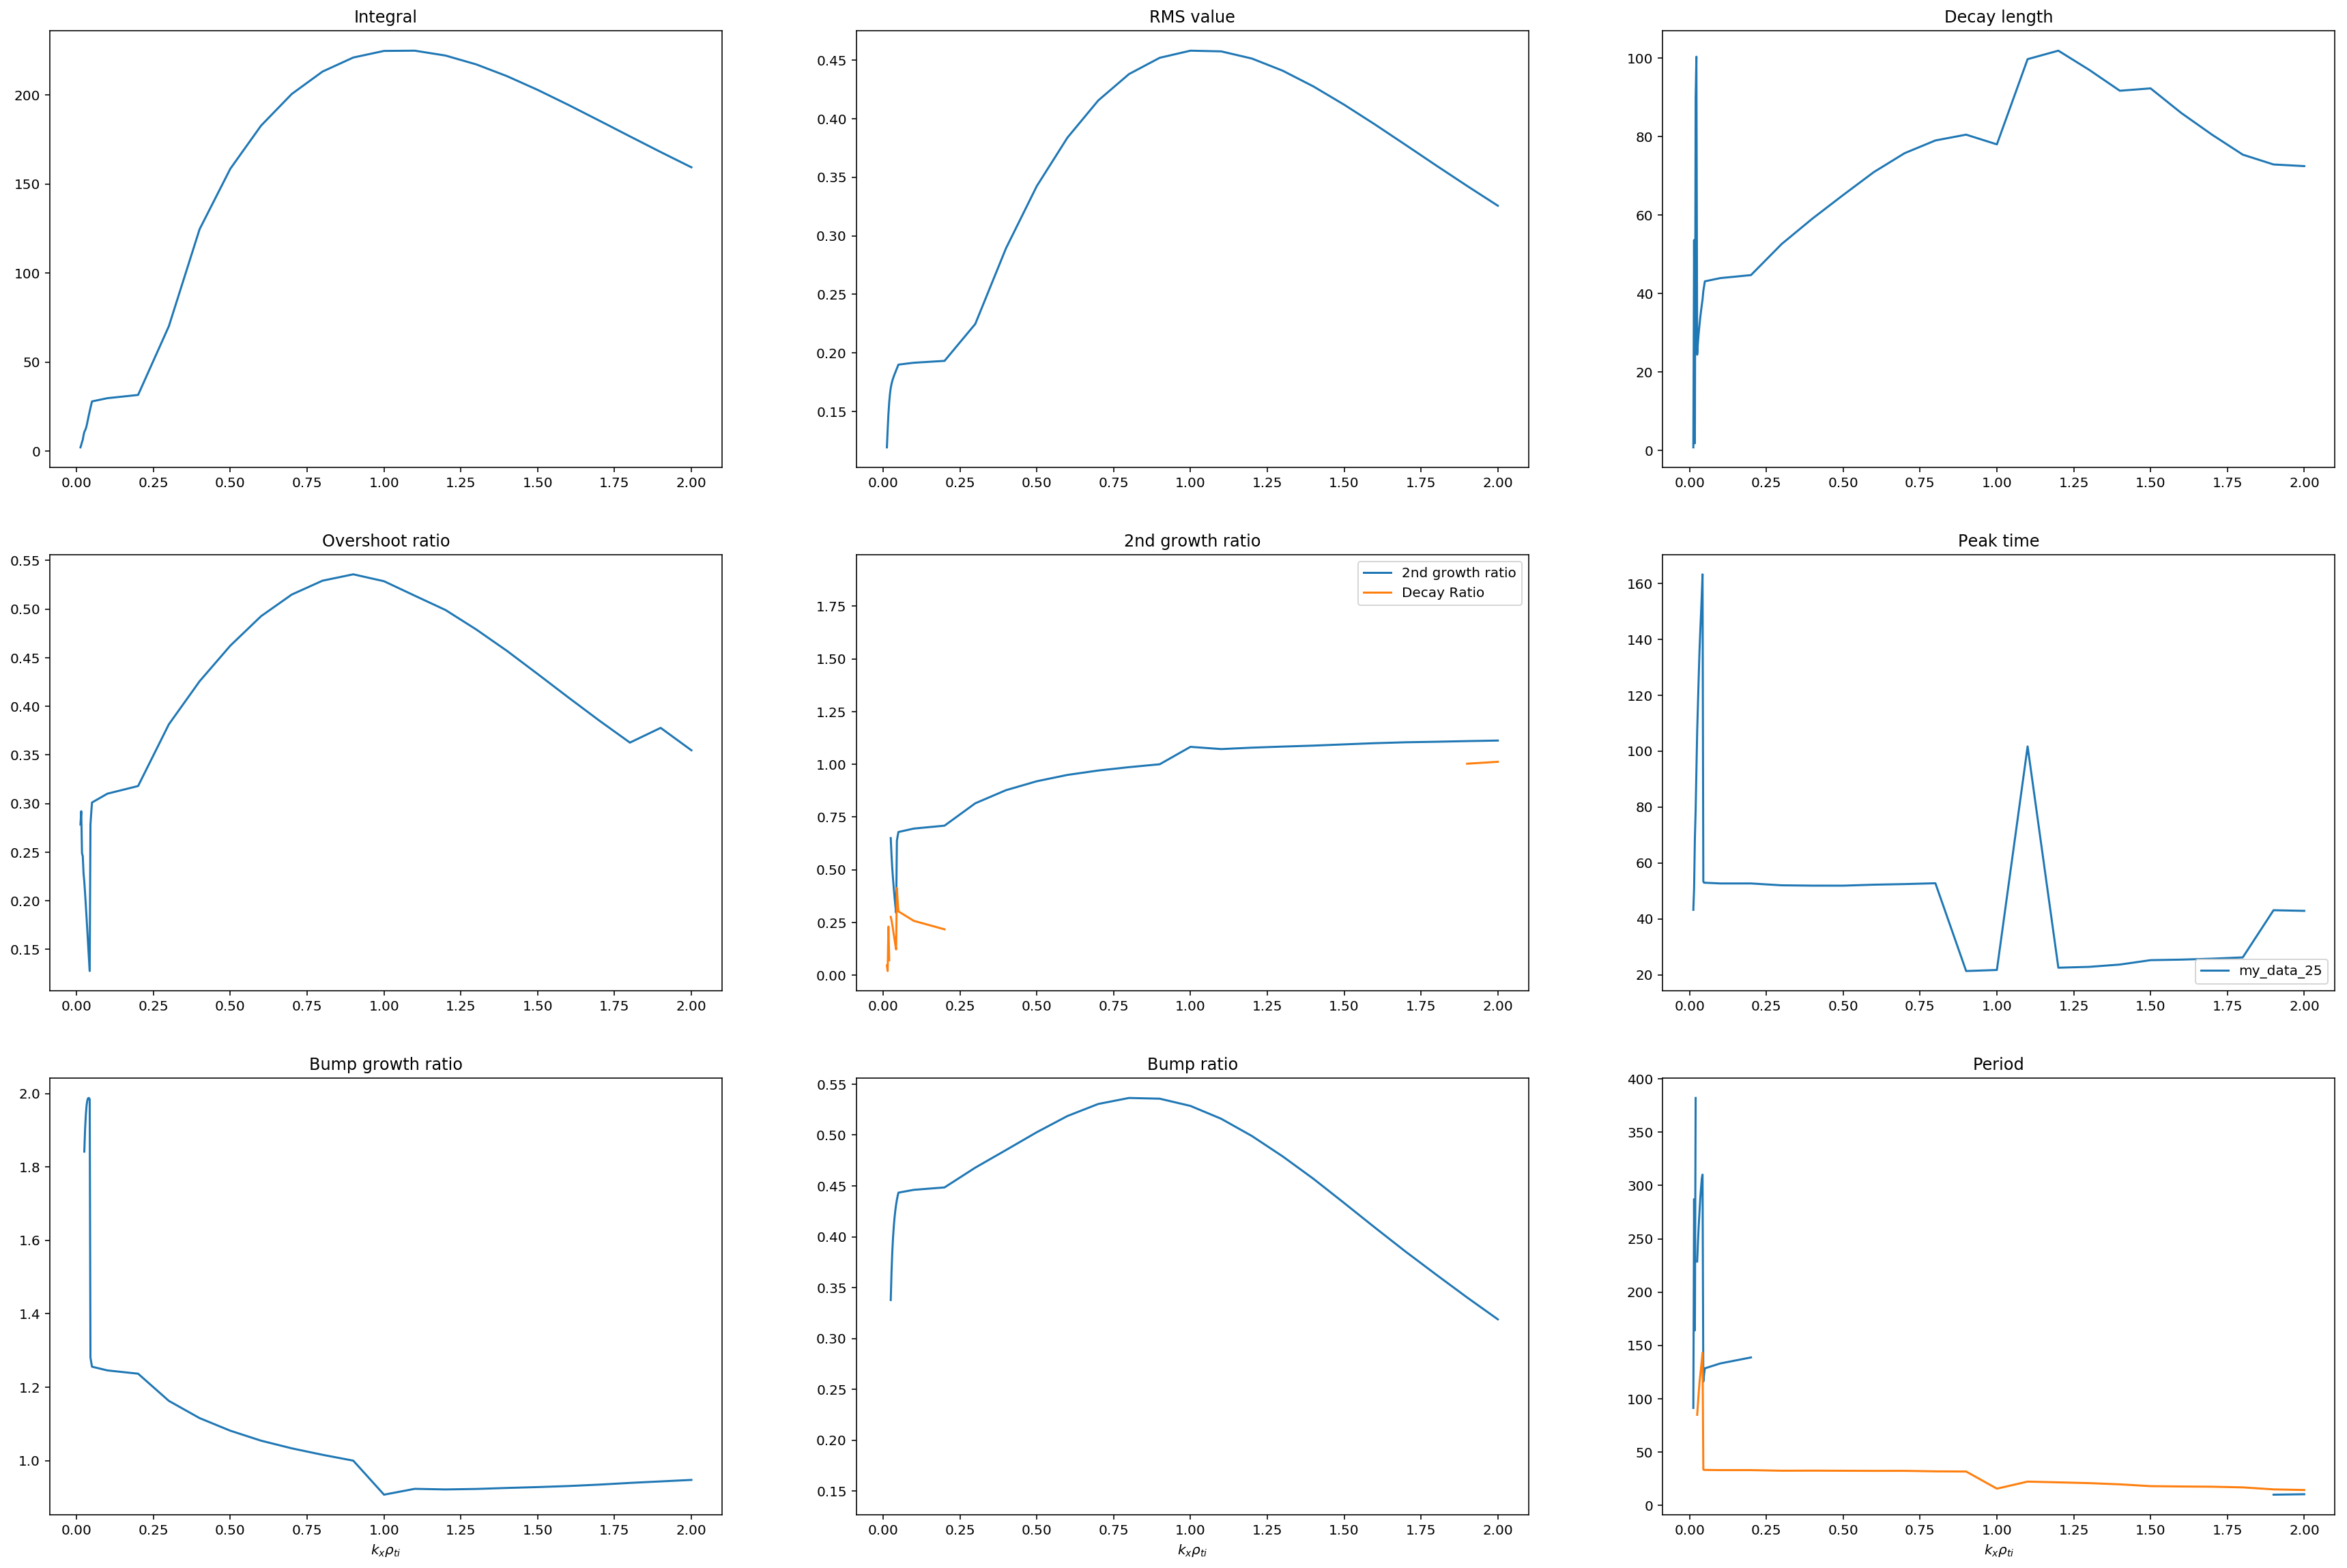

In [4]:
datalist, nummy, kx_25, my_data_25, E, t, f_s, label = diag_w7x('w7x-sc/s025', minlim=0, maxlim=19, plot=True)
datalist, nummy, kx_25b, my_data_25, E, t, f_s, label = diag_w7x('w7x-sc/s025/b_vals',minlim=1, maxlim=18, plot=True, my_data=my_data_25, k=18)
kx_25 = np.append(kx_25, kx_25b)
fig = diag_plotter(kx_25, my_data_25)


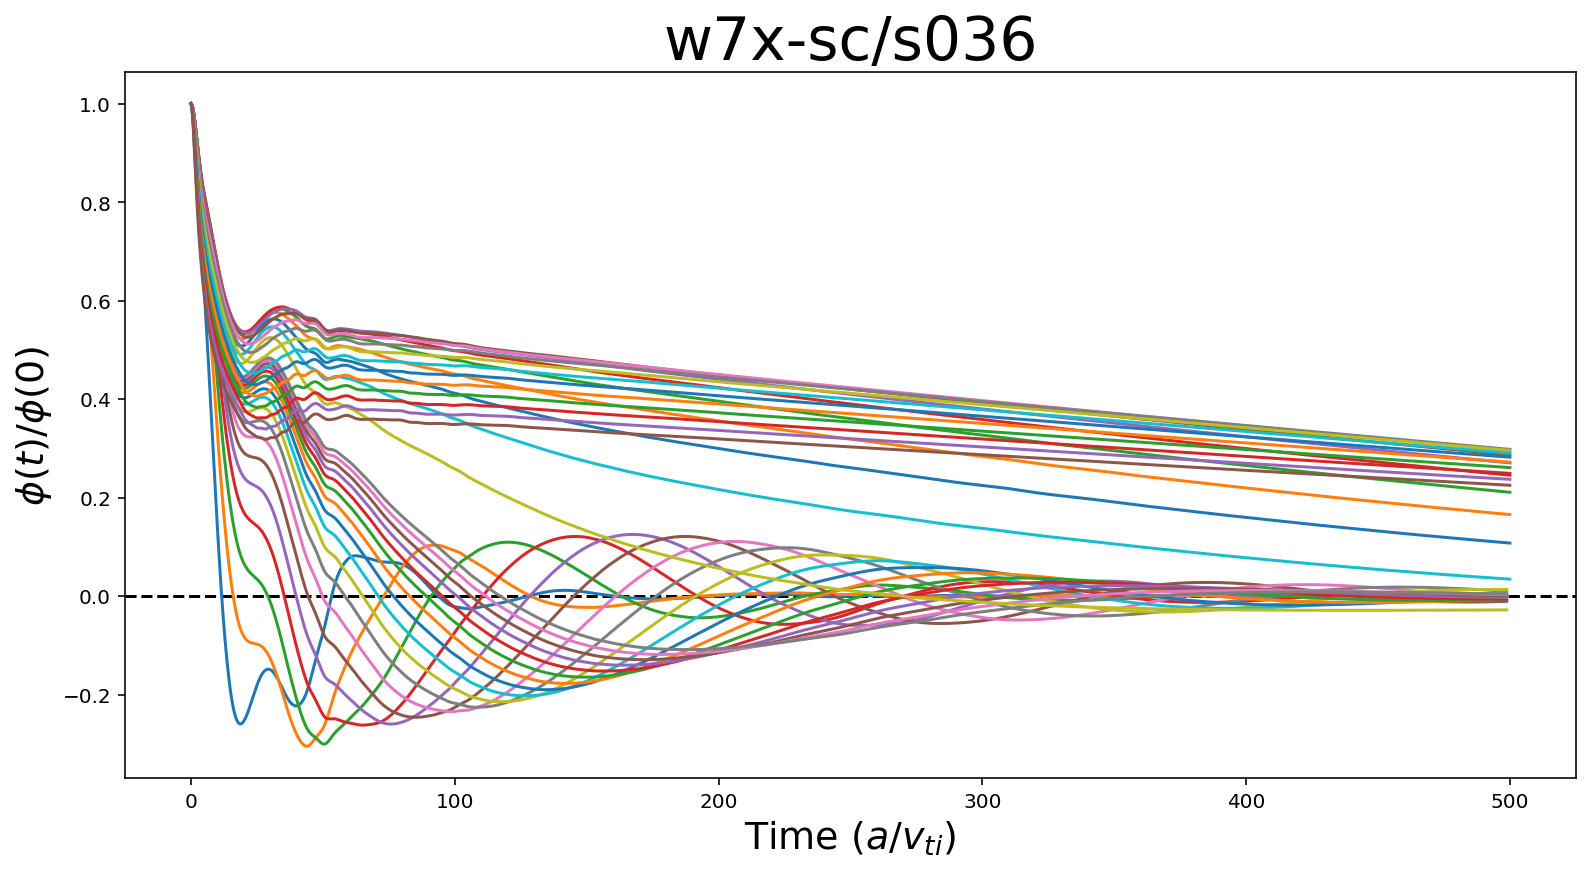

/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


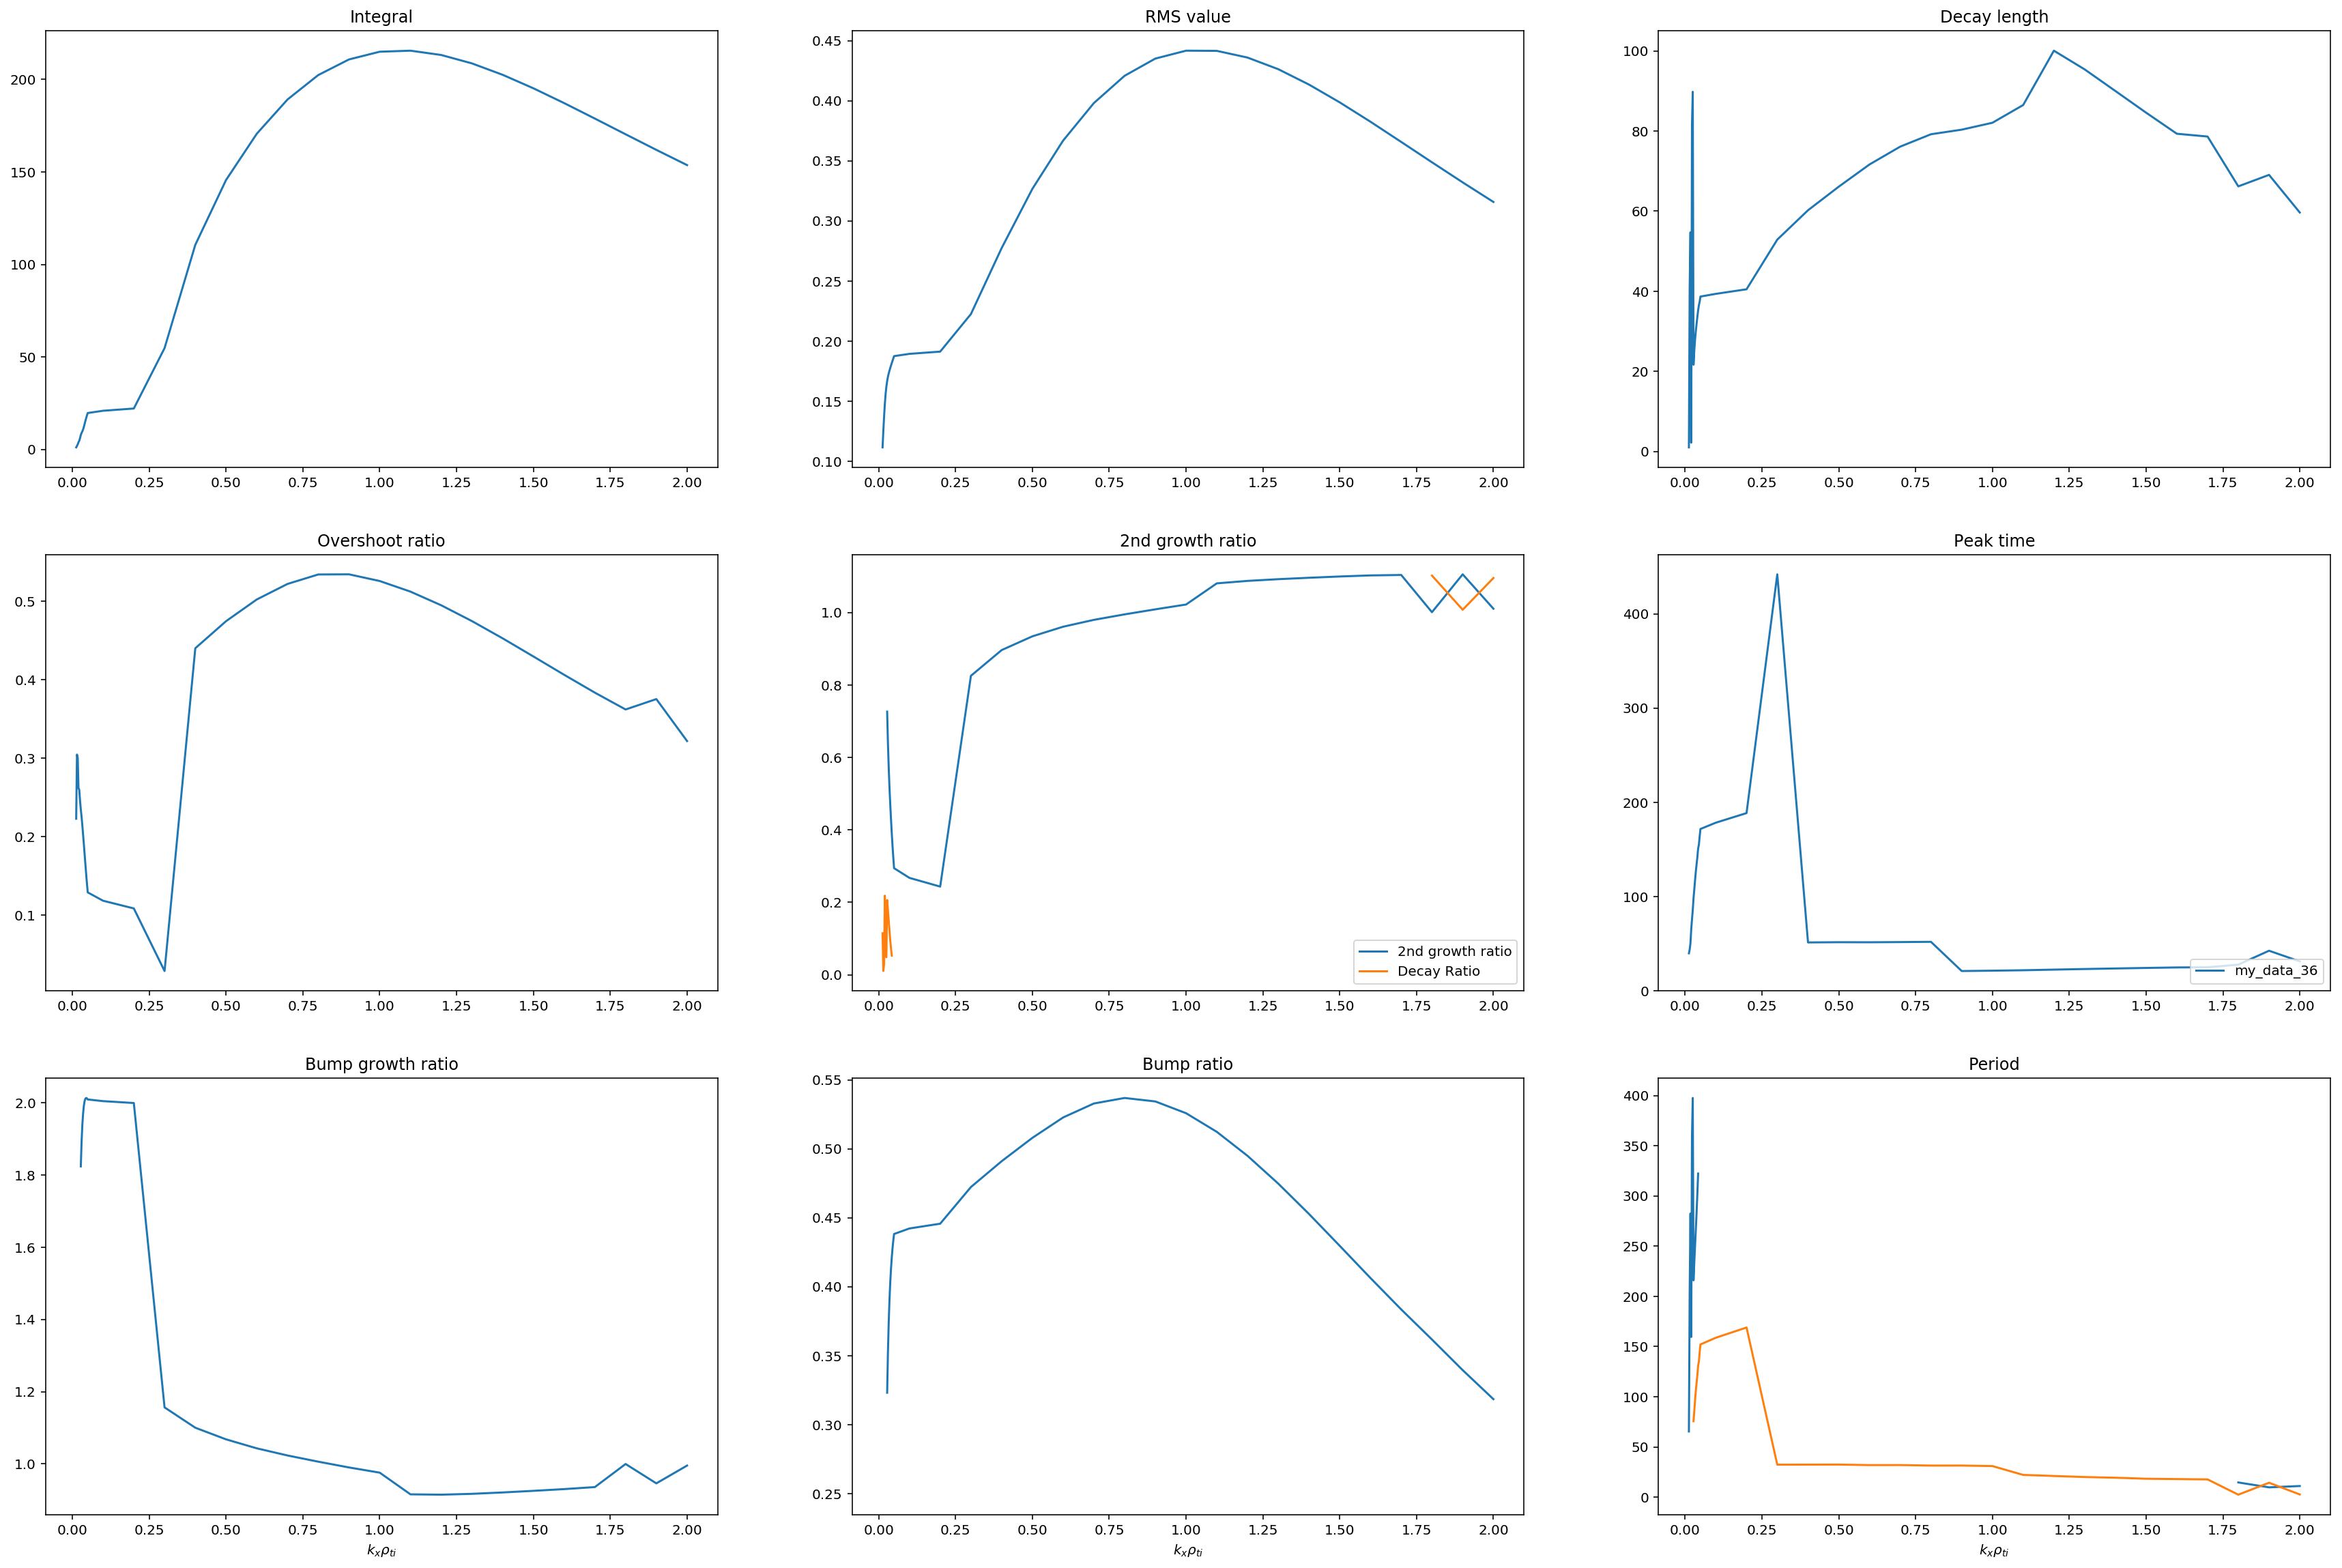

In [5]:
datalist, nummy, kx_36, my_data_36, E, t, f_s, label = diag_w7x('w7x-sc/s036', minlim=0, maxlim=19, plot=True)
datalist, nummy, kx_36b, my_data_36, E, t, f_s, label = diag_w7x('w7x-sc/s036/b_vals',minlim=1, maxlim=18, plot=True, my_data=my_data_36, k=18)
kx_36 = np.append(kx_36, kx_36b)
fig = diag_plotter(kx_36, my_data_36)
plt.show()

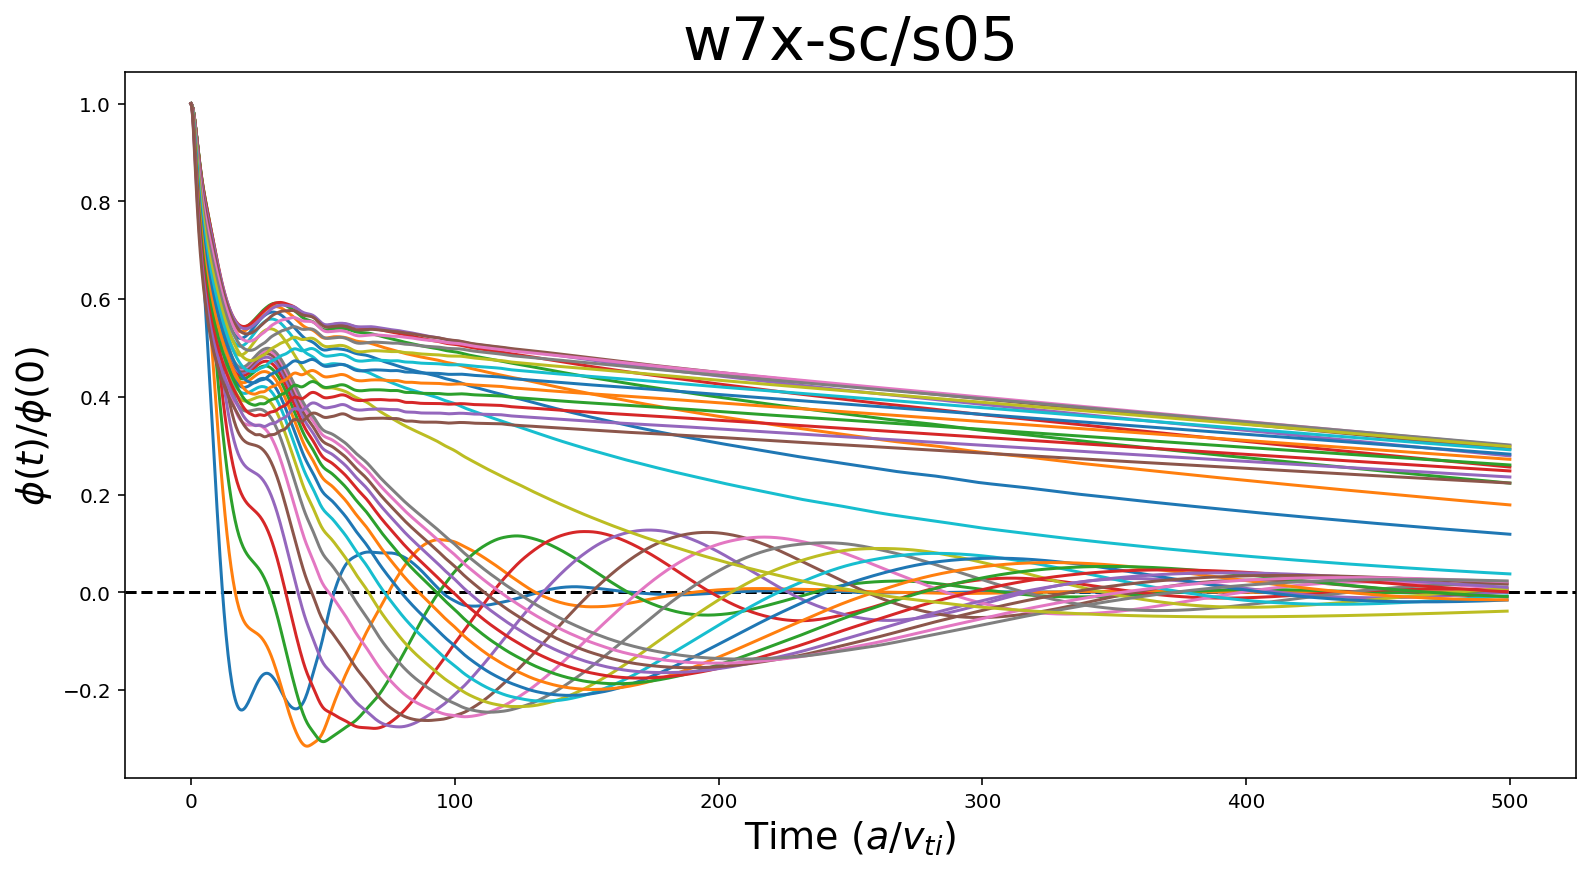

/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


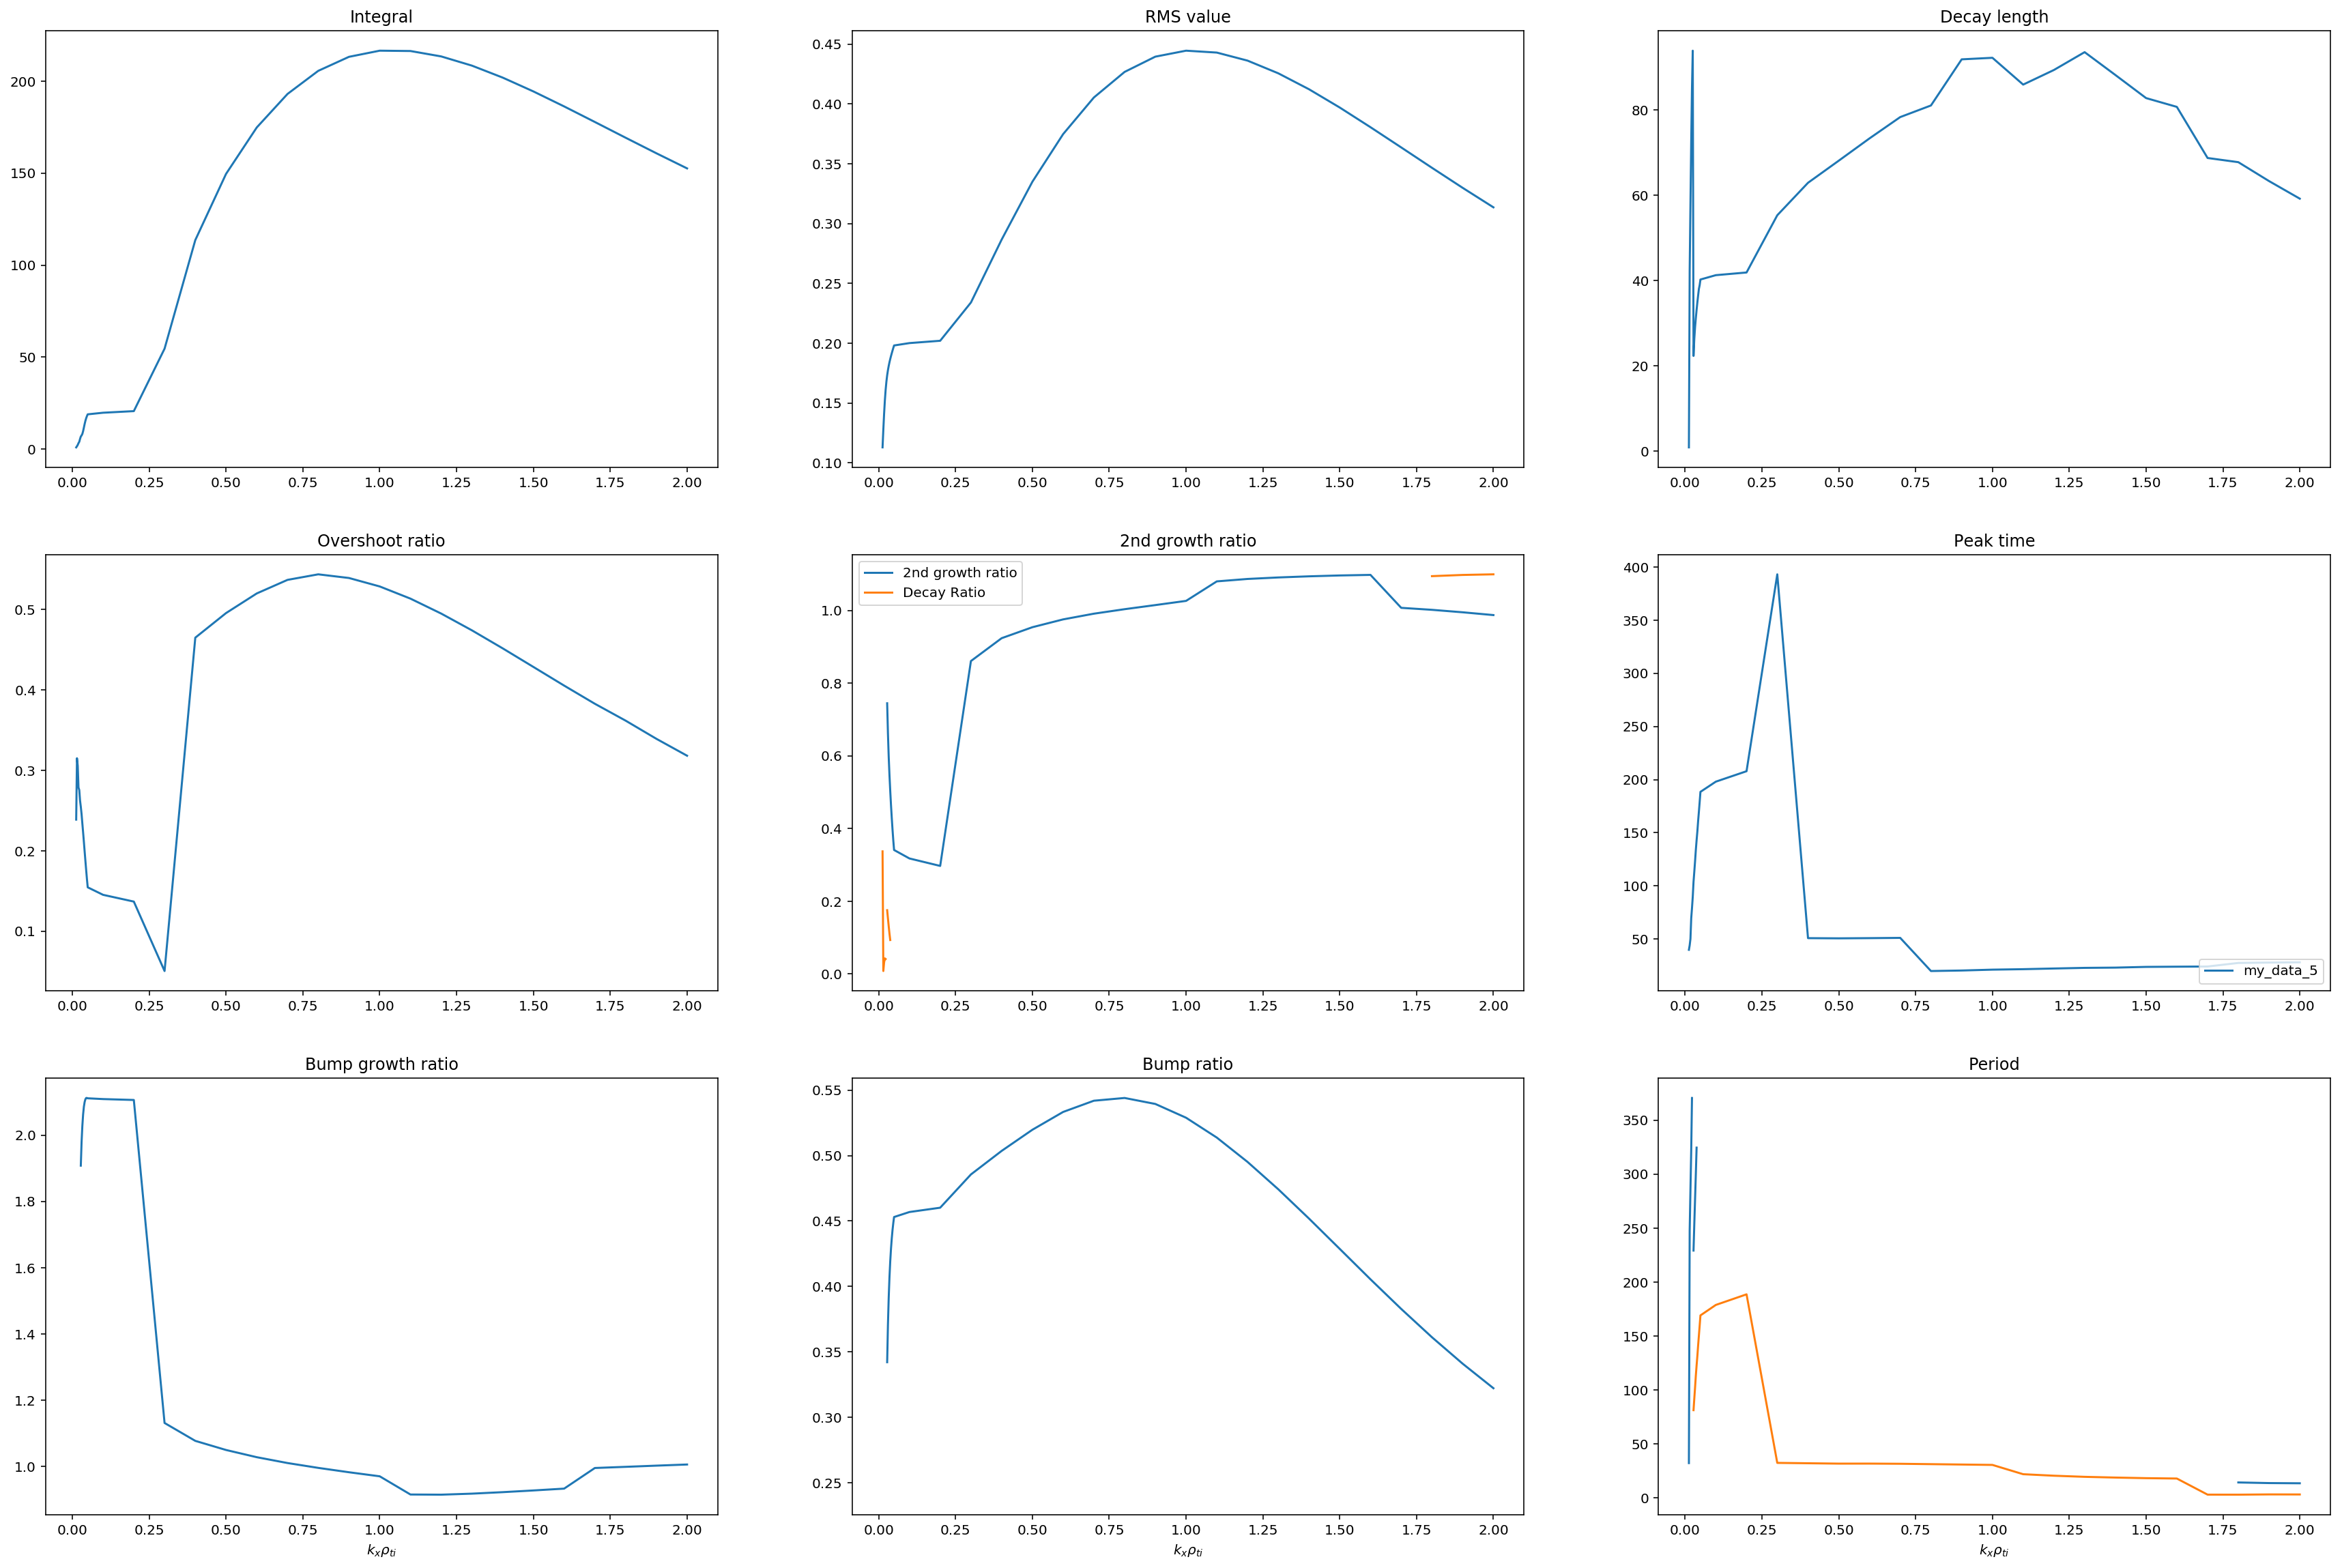

In [6]:
datalist, nummy, kx_5, my_data_5, E, t, f_s, label = diag_w7x('w7x-sc/s05', minlim=0, maxlim=19, plot=True)
datalist, nummy, kx_5b, my_data_5, E, t, f_s, label = diag_w7x('w7x-sc/s05/b_vals',minlim=1, maxlim=18, plot=True, my_data=my_data_5, k=18)
kx_5 = np.append(kx_5, kx_5b)
fig = diag_plotter(kx_5, my_data_5)
plt.show()

i point is the first one


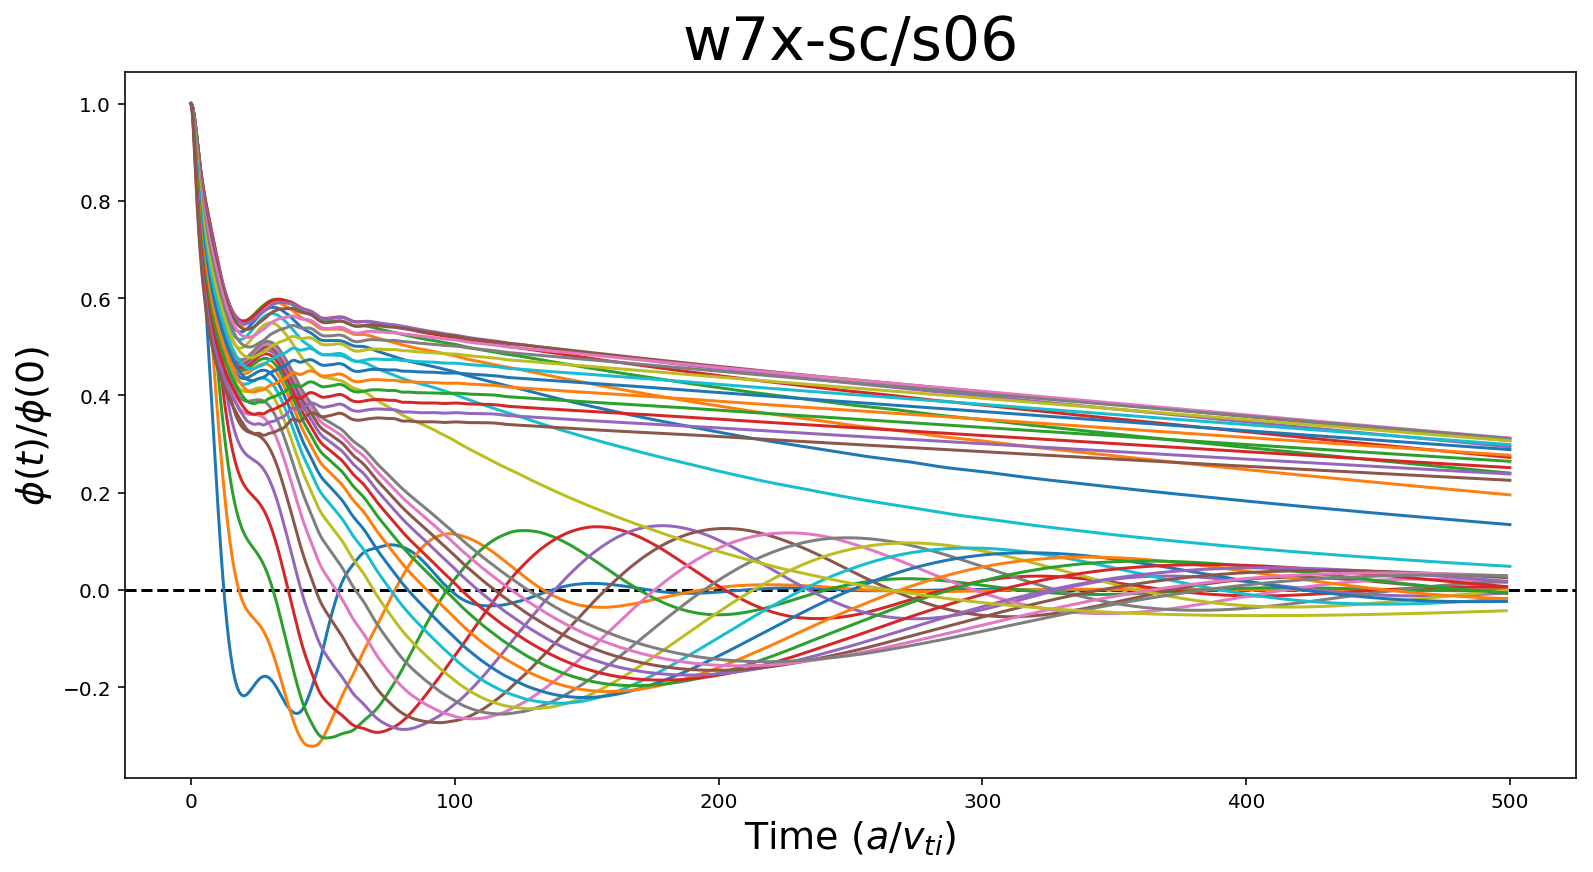

[0.0125 0.015  0.0175 0.02   0.0225 0.025  0.0275 0.03   0.0325 0.035
 0.0375 0.04   0.0425 0.045  0.0475 0.05   0.1    0.2    0.3    0.4
 0.5    0.6    0.7    0.8    0.9    1.     1.1    1.2    1.3    1.4
 1.5    1.6    1.7    1.8    1.9    2.    ]


/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


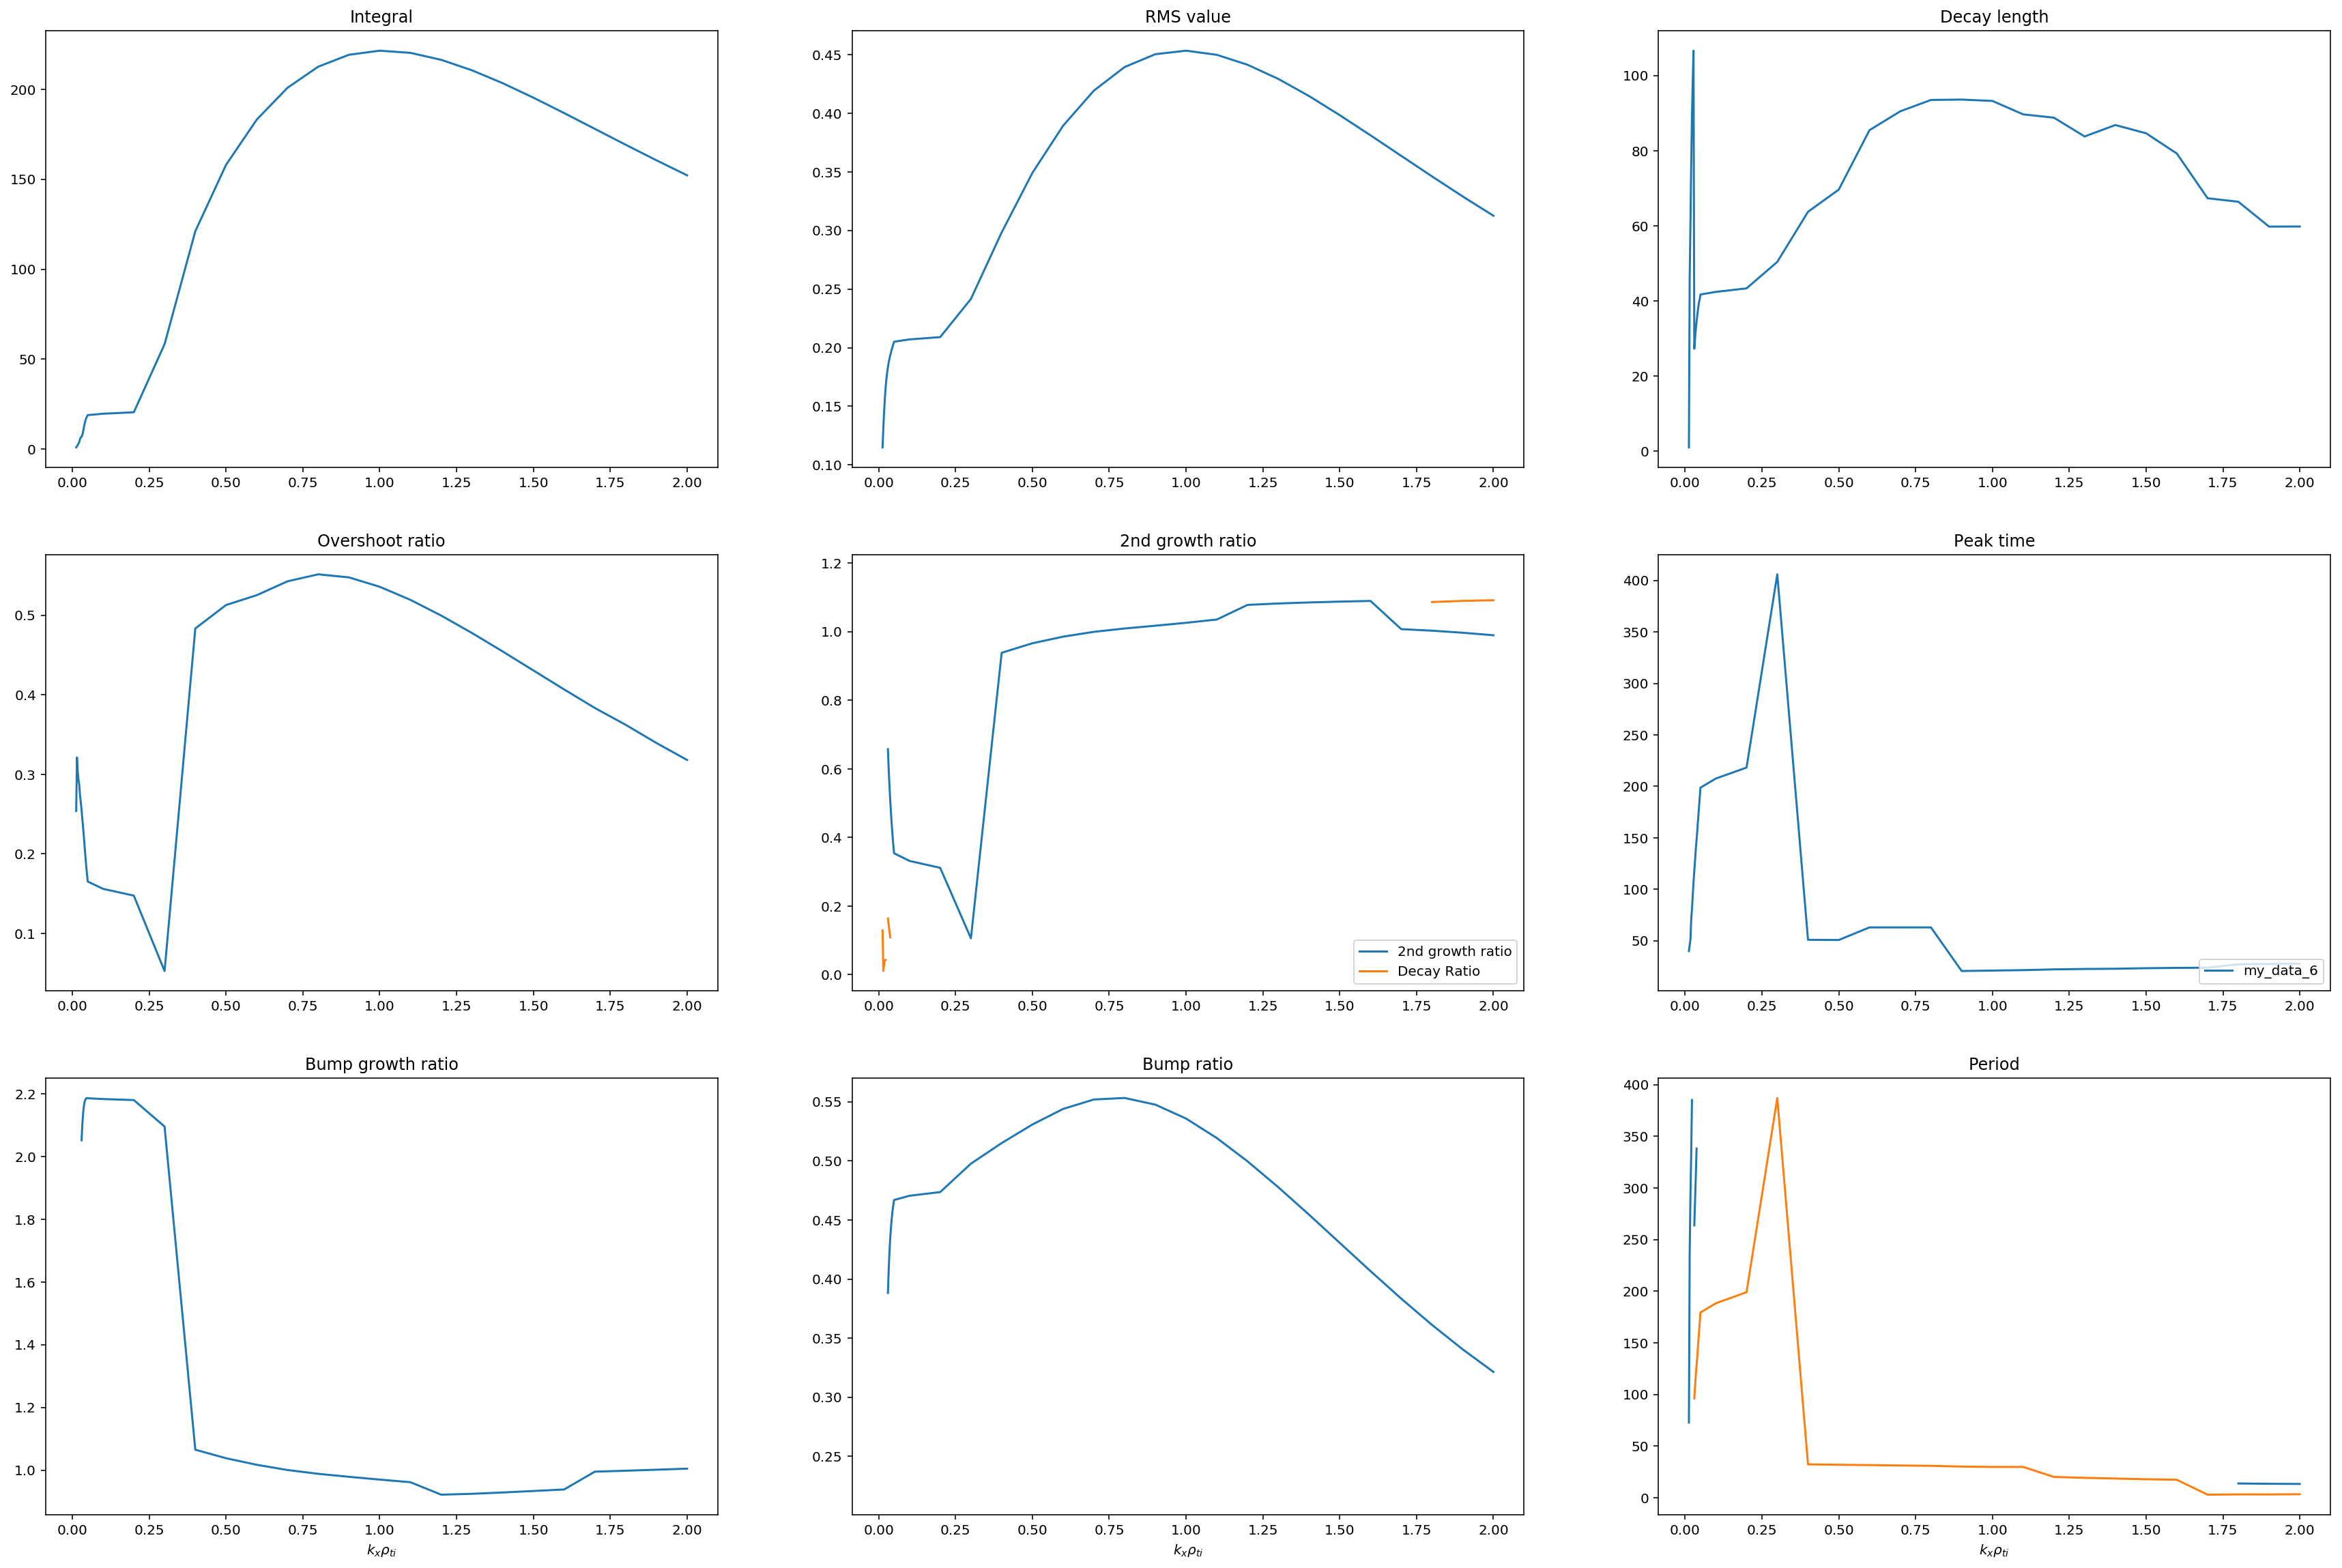

In [7]:
datalist, nummy, kx_6, my_data_6, E, t, f_s, label = diag_w7x('w7x-sc/s06', minlim=0, maxlim=19, plot=True)
datalist, nummy, kx_6b, my_data_6, E, t, f_s, label = diag_w7x('w7x-sc/s06/b_vals',minlim=1, maxlim=18, plot=True, my_data=my_data_6, k=18)
kx_6 = np.append(kx_6, kx_6b)
print(kx_6)
fig = diag_plotter(kx_6, my_data_6)
plt.show()

my_data_25
my_data_36
my_data_5
my_data_6


/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


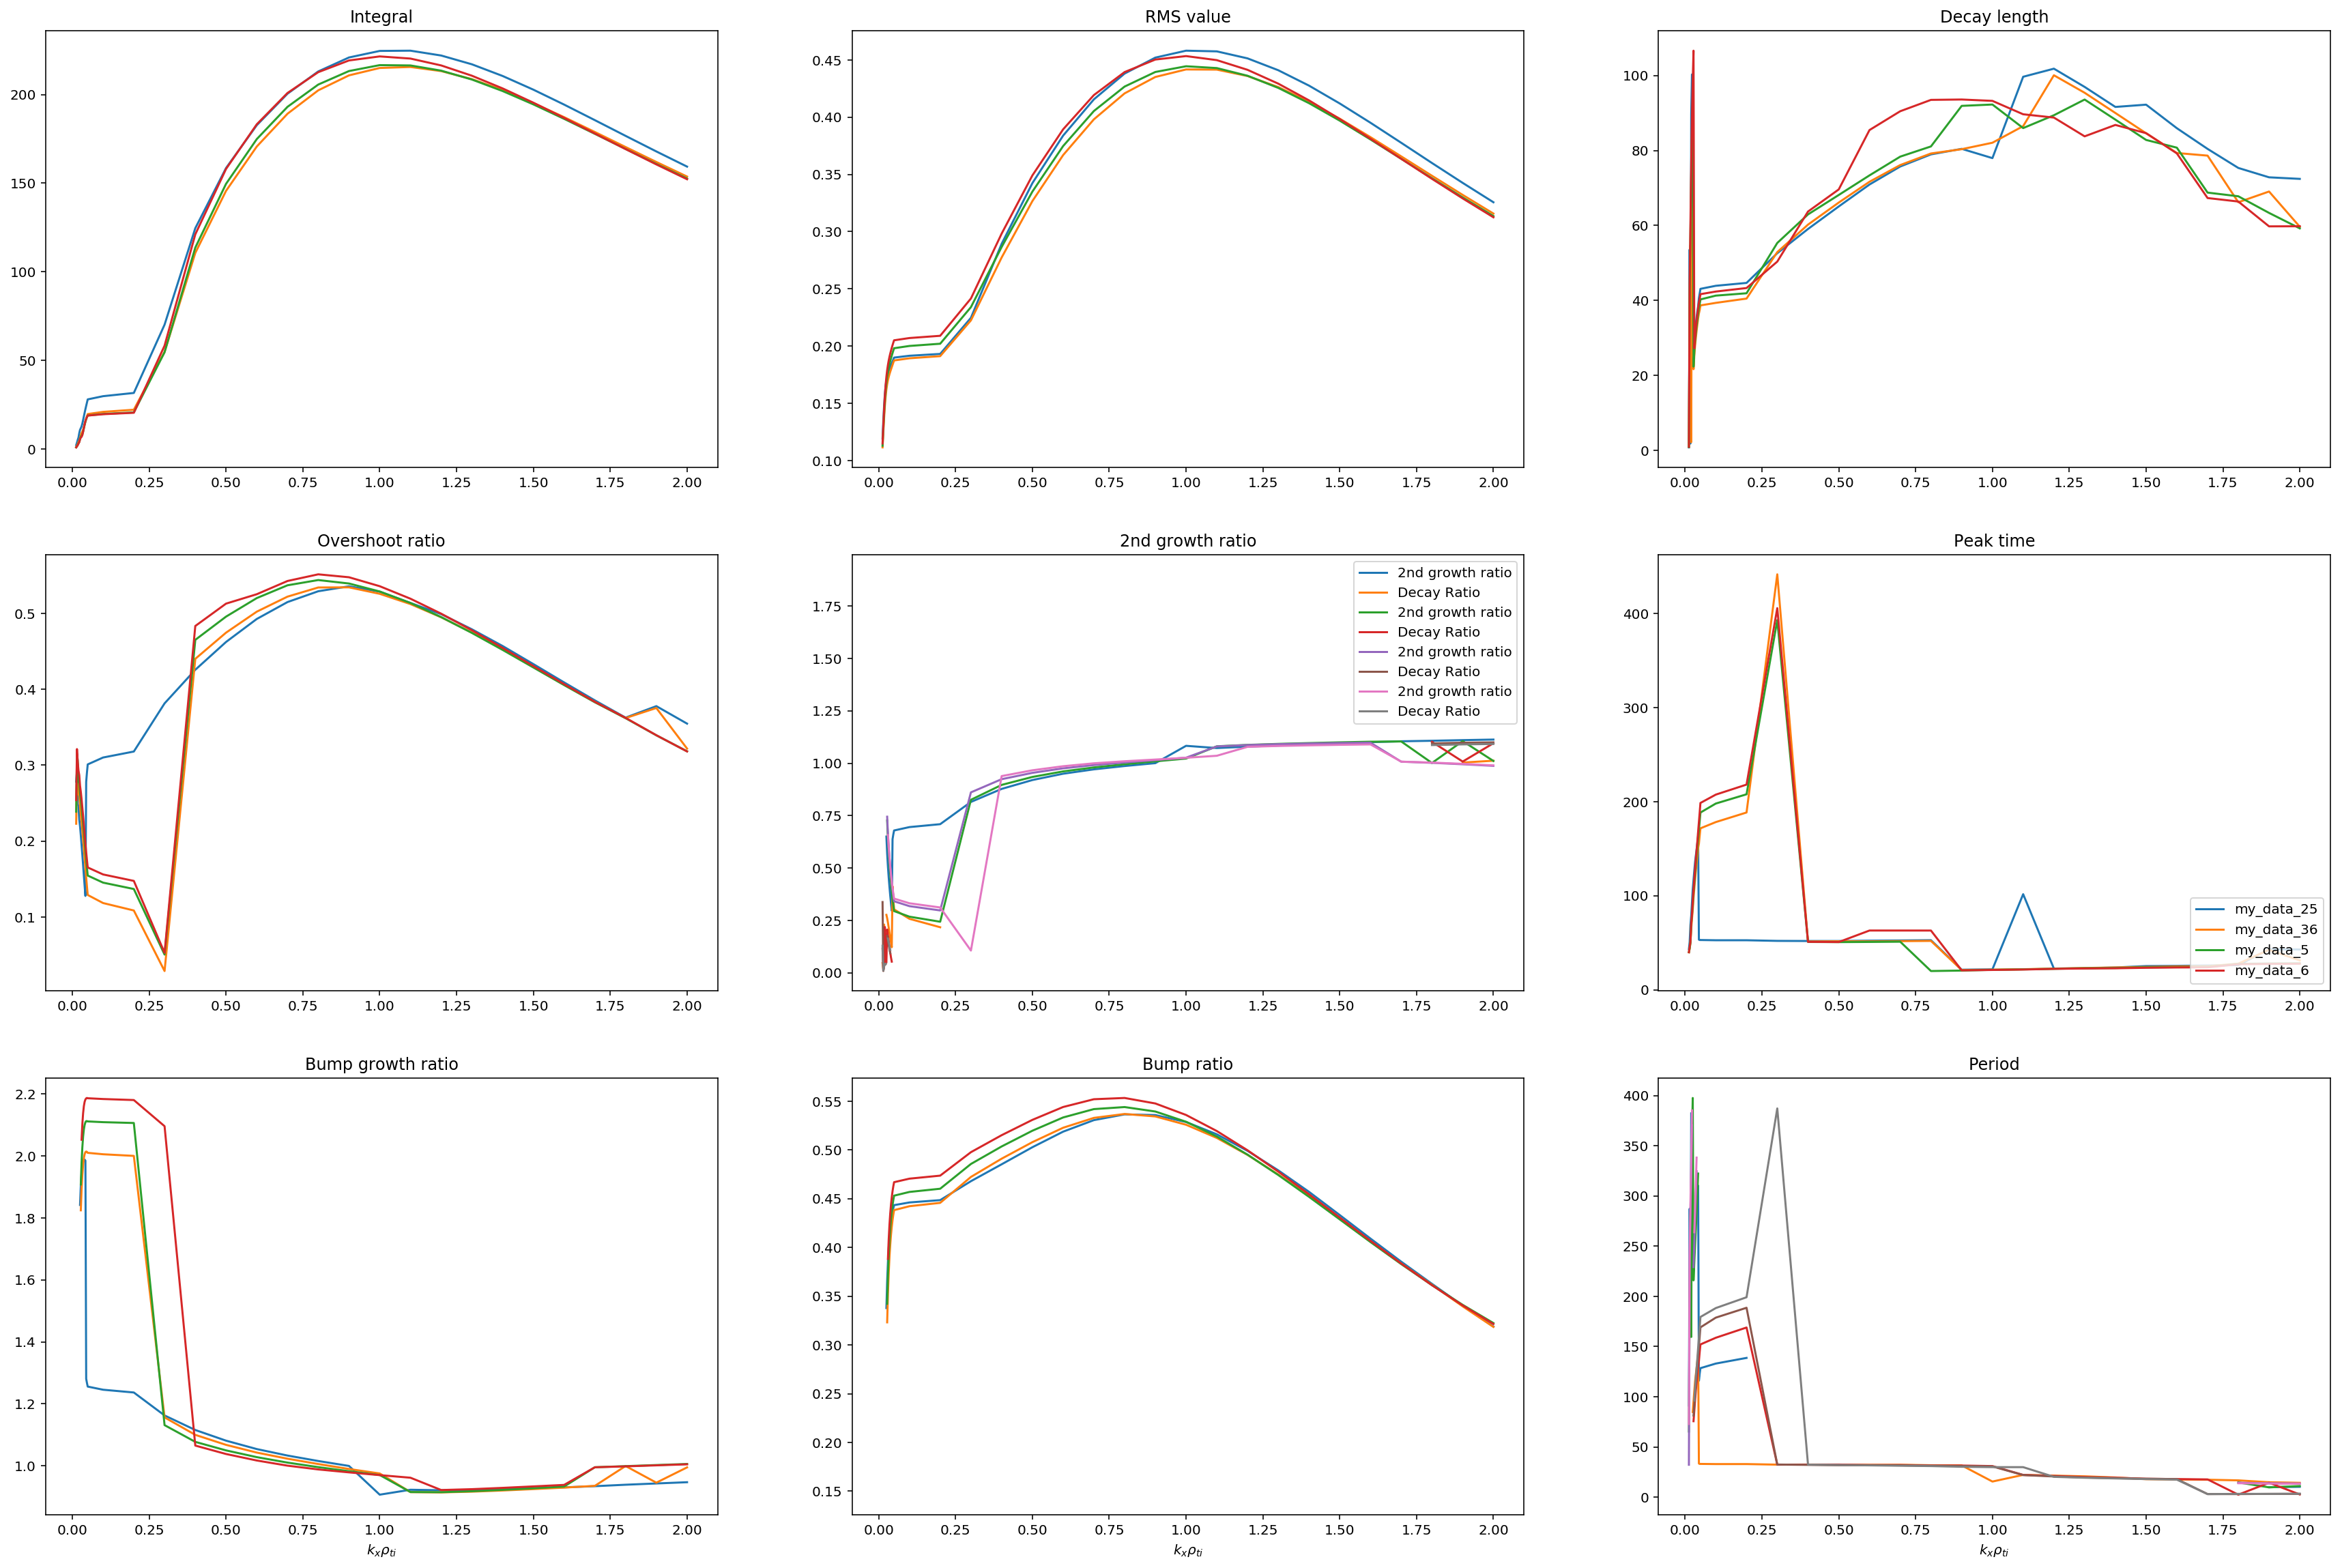

In [8]:
kekdata = my_data_25, my_data_36, my_data_5, my_data_6
kx = kx_25, kx_36, kx_5, kx_6
for d in range(0, 4):
    if retrieve_name(kekdata[d]) == retrieve_name(my_data_25):
        fig = diag_plotter(kx[d], kekdata[d], alldata=True, fig=True)
    else:
        fig = diag_plotter(kx[d], kekdata[d], alldata=True, fig=fig)
    print(retrieve_name(kekdata[d]))
plt.show()